In [1]:
# 1. Load Libraries
library(dplyr)
library(lubridate)
library(survival)
library(survminer)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: ggplot2

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma




In [2]:
# 1. Load Data
# Ensure your CSV has columns like: 'age', 'sex', 'year_diag'
raw_data <- read.csv("data/data.csv")

In [3]:
# 2. Final Prep for Plotting
# We need to calculate Time and re-order the factors (so the legend isn't alphabetical)
plot_data <- raw_data %>%
  mutate(
    # --- Fix Dates (Convert from Factor -> Text -> Date) ---
    Date_Diagnosis = ymd(as.character(Fecha_diag)),
    Date_LastContact = ymd(as.character(Fecha_ultcont)),
    Date_Death = ymd(as.character(Fecha_fall)),

    # --- Calculate Vital Status (1=Dead, 0=Alive) ---
    OS_status = case_when(
      Estado_vital == "Fallecido" ~ 1,
      Estado_vital == "Vivo" ~ 0,
      TRUE ~ NA_real_
    ),

    # --- Calculate Survival Time (Months) ---
    End_Date = if_else(OS_status == 1, Date_Death, Date_LastContact),
    OS_time = as.numeric(difftime(End_Date, Date_Diagnosis, units = "days")) / 30.4375,

    # --- Re-Level Factors (Crucial for correct Legend Order) ---
    # We force the logical order: None -> Primary -> Secondary -> Superior
    # (Otherwise R plots them alphabetically: Infante -> Ninguna -> Primaria...)
    Nivel_educ = factor(Nivel_educ,
                        levels = c("Ninguna", "Primaria", "Secundaria", "Superior")),

    # Order: IESS -> MSP -> SOLCA -> Private
    Establecimiento = factor(Establecimiento,
                             levels = c("IESS", "MSP", "SOLCA", "Privados no SOLCA"))
  ) %>%
  # Filter valid rows
  filter(!is.na(OS_time), OS_time > 0, !is.na(OS_status))

In [4]:
# 3. Fit Survival Models
fit_edu <- survfit(Surv(OS_time, OS_status) ~ Nivel_educ, data = plot_data)
fit_est <- survfit(Surv(OS_time, OS_status) ~ Establecimiento, data = plot_data)

In [5]:
# 4. Generate the Plots
# Define a clean theme
custom_theme <- function() {
  theme_classic(base_size = 14) +
  theme(plot.title = element_text(face = "bold"), axis.title = element_text(face = "bold"))
}

# Plot A: Education
p1 <- ggsurvplot(
  fit_edu, data = plot_data,
  size = 1, palette = "jco",
  conf.int = FALSE, pval = TRUE, pval.coord = c(10, 0.15),
  risk.table = TRUE, risk.table.height = 0.25,
  legend.labs = c("None", "Primary", "Secondary", "Superior"),
  title = "A. Survival by Education", xlab = "Time (Months)",
  ggtheme = custom_theme()
)

# Plot B: Health System
p2 <- ggsurvplot(
  fit_est, data = plot_data,
  size = 1, palette = "npg",
  conf.int = FALSE, pval = TRUE, pval.coord = c(10, 0.15),
  risk.table = TRUE, risk.table.height = 0.25,
  legend.labs = c("IESS", "MSP", "SOLCA", "Private"),
  title = "B. Survival by Establishment", xlab = "Time (Months)",
  ggtheme = custom_theme()
)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the ggpubr package.
  Please report the issue at <https://github.com/kassambara/ggpubr/issues>.”


In [6]:
# 5. Save the Multipanel Figure
dir.create("images", showWarnings = FALSE)
png("images/Figure4_KM_Curves.png", width = 16, height = 10, units = "in", res = 300)
arrange_ggsurvplots(list(p1, p2), print = TRUE, ncol = 2, nrow = 1)
dev.off()

print("Figure 4 saved to images/Figure4_KM_Curves.png")

Ignoring unknown labels:
• colour : "Strata"
Ignoring unknown labels:
• colour : "Strata"


png 
  2

[1] "Figure 4 saved to images/Figure4_KM_Curves.png"


In [7]:
# 4. Define "A4 Print" Theme
# base_size = 16 ensures main text is large.
custom_theme <- function() {
  theme_classic(base_size = 16) +
  theme(
    plot.title = element_text(face = "bold", size = 18),
    axis.title = element_text(face = "bold", size = 16),
    axis.text = element_text(size = 14, color = "black"), # Dark black text for print
    legend.text = element_text(size = 14),
    legend.title = element_text(face = "bold", size = 14)
  )
}


In [8]:

# 5. Generate Plots with Specific Font Controls
# Plot A: Education
p1 <- ggsurvplot(
  fit_edu, data = plot_data,
  size = 1.2,                 # Thicker lines for print visibility
  palette = "jco",
  conf.int = FALSE,

  # P-Value
  pval = TRUE,
  pval.size = 6,              # Larger P-value text
  pval.coord = c(10, 0.15),

  # Risk Table settings
  risk.table = TRUE,
  risk.table.height = 0.28,   # Slightly taller table
  fontsize = 5,               # Larger font inside the table (Default is 4)

  # Labels and Legends
  legend.labs = c("None", "Primary", "Secondary", "Superior"),
  title = "A. Survival by Education Level",
  xlab = "Time (Months)",
  ggtheme = custom_theme()
)

# Plot B: Health System
p2 <- ggsurvplot(
  fit_est, data = plot_data,
  size = 1.2,
  palette = "npg",
  conf.int = FALSE,

  # P-Value
  pval = TRUE,
  pval.size = 6,
  pval.coord = c(10, 0.15),

  # Risk Table settings
  risk.table = TRUE,
  risk.table.height = 0.28,
  fontsize = 5,

  # Labels
  legend.labs = c("IESS", "MSP", "SOLCA", "Private"),
  title = "B. Survival by Establishment",
  xlab = "Time (Months)",
  ggtheme = custom_theme()
)

# 6. Save with A4 Dimensions (Landscape)
# A4 Landscape is roughly 11.7 x 8.3 inches.
dir.create("images", showWarnings = FALSE)

png("images/Figure4_KM_Curves_A4_Large.png",
    width = 13,   # Slightly wider than A4 to fit the two panels side-by-side comfortably
    height = 8,   # Standard A4 height
    units = "in",
    res = 300)    # 300 DPI is required for print

arrange_ggsurvplots(list(p1, p2), print = TRUE, ncol = 2, nrow = 1)
dev.off()

print("Saved to images/Figure4_KM_Curves_A4_Large.png")

Ignoring unknown labels:
• colour : "Strata"
Ignoring unknown labels:
• colour : "Strata"


png 
  2

[1] "Saved to images/Figure4_KM_Curves_A4_Large.png"


Ignoring unknown labels:
• colour : "Strata"


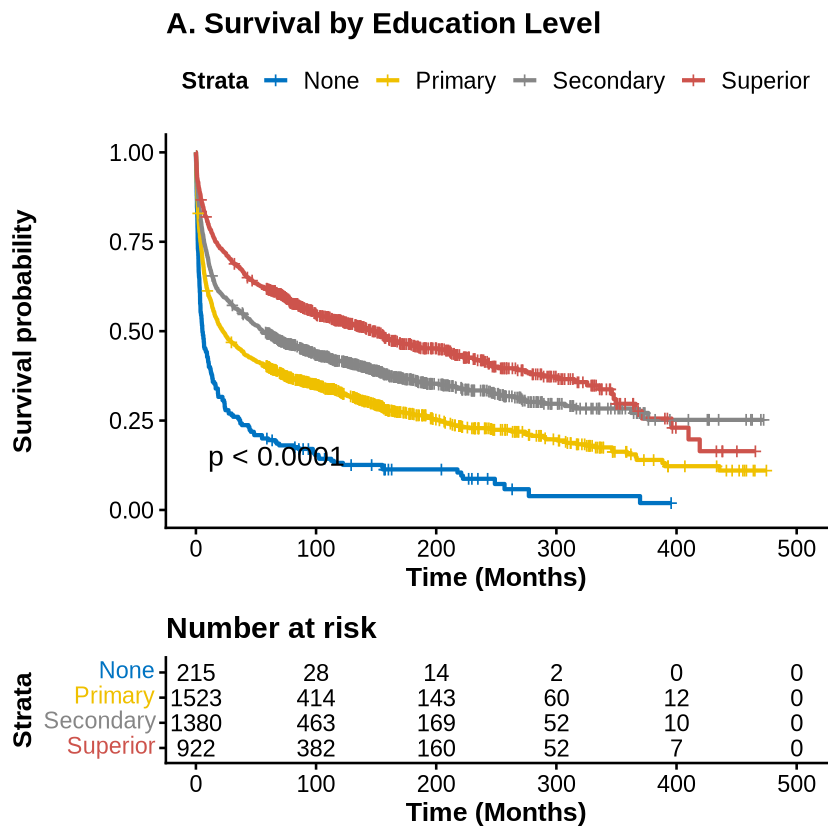

In [9]:
p1

Ignoring unknown labels:
• colour : "Strata"


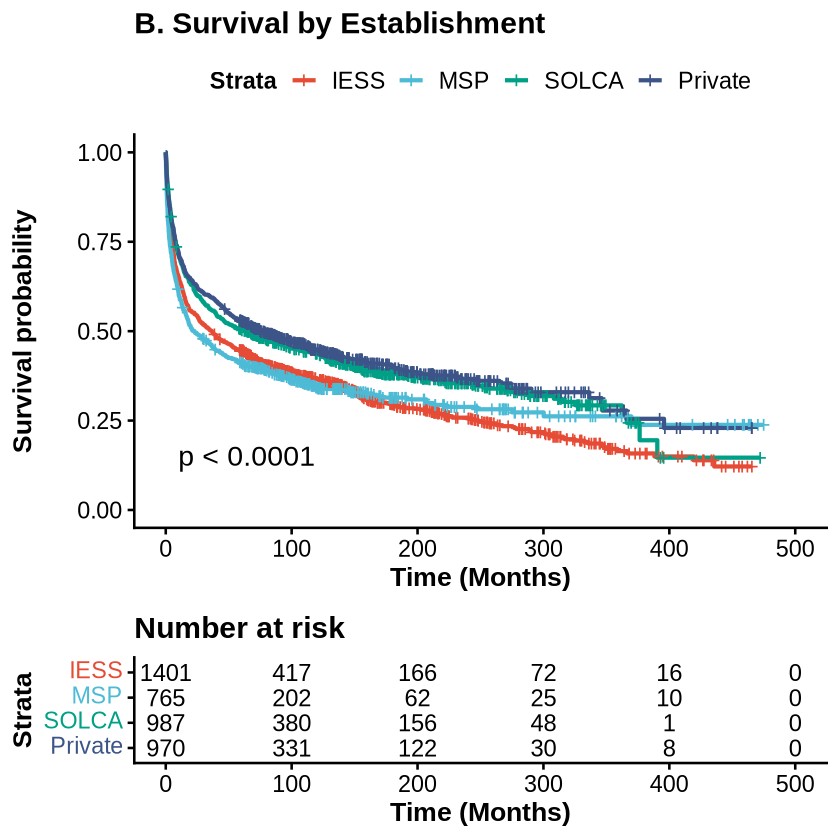

In [10]:
p2